In [5]:
import json
import numpy as np
from pathlib import Path
import sys
import os
import yaml

import sys 
import pathlib
import os
import numpy as np
import pandas as pd
#sys.path.append(os.path.abspath("/eos/home-b/bjlindst/SWAN_projects/lib"))
#import twissParser as tp
#import lossMapTools as lmt
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import lossmaps as lm
import pickle
np.set_printoptions(linewidth=100)
import scipy

import xobjects as xo
import xtrack as xt
import xpart as xp
import xcoll as xc

In [6]:
def find_axis_intercepts(x_coords, y_coords):
    x_intercepts = []
    y_intercepts = []

    for i in range(len(x_coords)):
        x1, y1 = x_coords[i], y_coords[i]
        x2, y2 = x_coords[(i + 1) % len(x_coords)], y_coords[(i + 1) % len(y_coords)]

        if x1 == x2:
        # Vertical line, no y-intercept
            y_intercept = 0.0 if x1 == x2 == 0.0 else None
        else:
            slope = (y2 - y1) / (x2 - x1)
            y_intercept = y1 - (slope * x1)

        if y1 == y2:
        # Horizontal line, no x-intercept
            x_intercept = 0.0 if y1 == y2 == 0.0 else None
        else:
            slope = (x2 - x1) / (y2 - y1)
            x_intercept = x1 - (slope * y1)

        # Check if the x-intercept is within the range of x1 and x2
        if x_intercept is not None and (x1 <= x_intercept <= x2 or x2 <= x_intercept <= x1):
            x_intercepts.append(x_intercept)

        # Check if the y-intercept is within the range of y1 and y2
        if y_intercept is not None and (y1 <= y_intercept <= y2 or y2 <= y_intercept <= y1):
            y_intercepts.append(y_intercept)

    return x_intercepts, y_intercepts



def find_bad_offset_apertures(line):
    aperture_offsets = {}
    for name, element in line.element_dict.items():
        if 'offset' in name and element.__class__.__name__.startswith('XYShift'):
            aper_name = name.split('_offset')[0]
            aperture_offsets[aper_name] = (element.dx, element.dy)

    bad_apers = {}
    for ap_name, offset in aperture_offsets.items():
        aperture_el = line.element_dict[ap_name]

        cname= aperture_el.__class__.__name__
        ap_dict = aperture_el.to_dict()

        if cname == 'LimitEllipse':
            x_min = -ap_dict['a']
            x_max = ap_dict['a']
            y_min = -ap_dict['b']
            y_max = ap_dict['b']
        elif cname == 'LimitRect':
            x_min = ap_dict['min_x']
            x_max = ap_dict['max_x']
            y_min = ap_dict['min_y']
            y_max = ap_dict['max_y']
        elif cname == 'LimitRectEllipse':
            x_min = -ap_dict['max_x']
            x_max = ap_dict['max_x']
            y_min = -ap_dict['max_y']
            y_max = ap_dict['max_y']
        elif cname == 'LimitRacetrack':
            x_min = ap_dict['min_x']
            x_max = ap_dict['max_x']
            y_min = ap_dict['min_y']
            y_max = ap_dict['max_y']
        elif cname == 'LimitPolygon':
            x_intercepts, y_intercepts = find_axis_intercepts(ap_dict['x_vertices'],
                                                            ap_dict['y_vertices'])
            x_min = min(x_intercepts)
            x_max = max(x_intercepts)
            y_min = min(y_intercepts)
            y_max = max(y_intercepts)

        tolerance = 5e-3
        """if (x_max - offset[0] < tolerance 
            or -x_min + offset[0] < tolerance 
            or y_max - offset[1] < tolerance 
            or -y_min + offset[1] < tolerance):"""
        if (offset[0] -x_max > tolerance 
            or  -offset[0] + x_min > tolerance 
            or  offset[1] - y_max > tolerance 
            or  -offset[1] + y_min > tolerance ):
                bad_apers[ap_name] = (x_min, x_max, y_min, y_max, offset[0], offset[1])

    return bad_apers

In [7]:
import io

def load_colldb_new(filename):
    with open(filename, "r") as infile:
        coll_data_string = ""
        family_settings = {}
        family_types = {}
        onesided = {}
        tilted = {}
        bend = {}
        xdim = {}
        ydim = {}

        for l_no, line in enumerate(infile):
            if line.startswith("#"):
                continue  # Comment
            if len(line.strip()) == 0:
                continue  # Empty line
            sline = line.split()
            if len(sline) < 6 or sline[0].lower() == "crystal" or sline[0].lower() == "target":
                if sline[0].lower() == "nsig_fam":
                    family_settings[sline[1]] = sline[2]
                    family_types[sline[1]] = sline[3]
                elif sline[0].lower() == "onesided":
                    onesided[sline[1]] = int(sline[2])
                elif sline[0].lower() == "tilted":
                    tilted[sline[1]] = [float(sline[2]), float(sline[3])]
                elif sline[0].lower() == "crystal":
                    bend[sline[1]] = float(sline[2])
                    xdim[sline[1]] = float(sline[3])
                    ydim[sline[1]] = float(sline[4])
                elif sline[0].lower() == "target":
                    xdim[sline[1]] = float(sline[2])
                    ydim[sline[1]] = float(sline[3])
                elif sline[0].lower() == "settings":
                    pass  # Acknowledge and ignore this line
                else:
                    raise ValueError(f"Unknown setting {line}")
            else:
                coll_data_string += line

    names = ["name", "opening", "material", "length", "angle", "offset"]

    df = pd.read_csv(io.StringIO(coll_data_string), delim_whitespace=True,
                     index_col=False, skip_blank_lines=True, names=names)

    df["angle"] = df["angle"] 
    df["name"] = df["name"].str.lower() # Make the names lowercase for easy processing
    df["nsigma"] = df["opening"].apply(lambda s: float(family_settings.get(s, s)))
    df["type"] = df["opening"].apply(lambda s: family_types.get(s, "UNKNOWN"))
    df["side"] = df["name"].apply(lambda s: onesided.get(s, 0))
    df["bend"] = df["name"].apply(lambda s: bend.get(s, 0))
    df["xdim"] = df["name"].apply(lambda s: xdim.get(s, 0))
    df["ydim"] = df["name"].apply(lambda s: ydim.get(s, 0))
    df["tilt_left"] = df["name"].apply(lambda s: np.deg2rad(tilted.get(s, [0, 0])[0]))
    df["tilt_right"] = df["name"].apply(lambda s: np.deg2rad(tilted.get(s, [0, 0])[1]))
    df = df.set_index("name").T

    # Ensure the collimators marked as one-sided or tilted are actually defined
    defined_set = set(df.columns) # The data fram was transposed so columns are names
    onesided_set = set(onesided.keys())
    tilted_set = set(tilted.keys())
    if not onesided_set.issubset(defined_set):
        different = onesided_set - defined_set
        raise SystemExit('One-sided collimators not defined: {}'.format(", ".join(different)))
    if not tilted_set.issubset(defined_set):
        different = tilted_set - defined_set
        raise SystemExit('Tilted collimators not defined: {}'.format(",".join(different)))
    return df.T

In [8]:
beam          = 2   #run_dict['beam']
plane         = "V" #run_dict['plane']
TCCS_name     = 'tccs.5r3.b2'
TCCP_name     = 'tccp.4l3.b2'
TARGET_name   = 'target.4l3.b2'
TCLA_name     = 'tcla.a5l3.b2'
TCP_name      = f"tcp.{'c' if plane=='H' else 'd'}6{'l' if beam=='1' else 'r'}7.b{beam}"
context = xo.ContextCpu(omp_num_threads='auto')

In [9]:
coll_file_HL_IR7 = os.path.expandvars('${HOME_TWOCRYST}/input_files/CollDB_HL_tight_b4.data')
line_name_HL_IR7 = os.path.expandvars("${HOME_TWOCRYST}/input_files/HL_IR7_rematched/b4_sequence_patched.json")
particle_ref_HL = xp.Particles(p0c=7000e9, q0=1, mass0=xp.PROTON_MASS_EV)

In [10]:
if coll_file_HL_IR7.endswith('.yaml'):
    with open(coll_file_HL_IR7, 'r') as stream:
        coll_dict = yaml.safe_load(stream)['collimators'][f'b{beam}']
if coll_file_HL_IR7.endswith('.data'):
    coll_dict = load_colldb_new(coll_file_HL_IR7).to_dict('index')


# Load from json
line = xt.Line.from_json(line_name_HL_IR7)
line.particle_ref = particle_ref_HL

end_s = line.get_length()

TCCS_loc = end_s - 6773.7 #6775
TCCP_loc = end_s - 6653.3 #6655
TARGET_loc = end_s - (6653.3 + coll_dict[TCCP_name]["length"]/2 + coll_dict[TARGET_name]["length"]/2)

line.insert_element(at_s=TCCS_loc, element=xt.Marker(), name='tccs.5r3.b2')
line.insert_element(at_s=TCCS_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name='tccs.5r3.b2_aper')
line.insert_element(at_s=TCCP_loc, element=xt.Marker(), name='tccp.4l3.b2')
line.insert_element(at_s=TCCP_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name='tccp.4l3.b2_aper')
line.insert_element(at_s=TARGET_loc, element=xt.Marker(), name='target.4l3.b2')
line.insert_element(at_s=TARGET_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name='target.4l3.b2_aper')


bad_aper = find_bad_offset_apertures(line)
print('Bad apertures : ', bad_aper)
print('Replace bad apertures with Marker')
for name in bad_aper.keys():
    line.element_dict[name] = xt.Marker()
    print(name, line.get_s_position(name), line.element_dict[name])

Done loading line from dict.           
Bad apertures :  {}
Replace bad apertures with Marker


In [11]:
speed = line.particle_ref._xobject.beta0[0]*scipy.constants.c
harmonic_number = 35640
voltage = 12e6/len(line.get_elements_of_type(xt.Cavity)[1])
frequency = harmonic_number * speed /line.get_length()

for side in ['l', 'r']:
    for cell in ['a','b','c','d']:
        line[f'acsca.{cell}5{side}4.b2'].voltage = voltage
        line[f'acsca.{cell}5{side}4.b2'].frequency = frequency

In [30]:
num_part = 1000
num_turn = 100

In [31]:
"""part = xp.Particles(p0c=7000e9, #eV
                        q0=1, mass0=xp.PROTON_MASS_EV,
                        zeta = np.random.uniform(-1,1,num_part),
                        delta = np.random.uniform(-1e-3,1e-3,num_part),
                        _context=context)"""

In [35]:
bunch_intensity = 1e11
sigma_z = 22.5e-2
n_part = int(5e5)
nemitt_x = 2e-6
nemitt_y = 2.5e-6

In [37]:
part = xp.generate_matched_gaussian_bunch(
         num_particles=n_part, total_intensity_particles=bunch_intensity,
         nemitt_x=nemitt_x, nemitt_y=nemitt_y, sigma_z=sigma_z,
         line=line)

Given RMS bunch length does not fit into bucket. Using (maximum) full bucket RMS bunch length 0.1167161993796597m instead.


*** Maximum RMS bunch length 0.11789515088854516m.


RFBucketMatcher: failed to converge with Brent method, continuing with Newton-Raphson method.


... distance to target bunch length: -1.1672e-01
... distance to target bunch length: -2.0781e-03
... distance to target bunch length: -1.3382e-02
... distance to target bunch length: -1.3351e-02
... distance to target bunch length: -5.6329e-03
... distance to target bunch length: -3.3331e-03
... distance to target bunch length: -1.6270e-03
... distance to target bunch length: -7.6769e-04
... distance to target bunch length: -2.9603e-04
... distance to target bunch length: -8.2883e-05
... distance to target bunch length: -1.2366e-05
... distance to target bunch length: -6.1347e-07
... distance to target bunch length: -4.8022e-09
--> Bunch length: 0.11671619937777845
--> Emittance: 4.0445787989647055


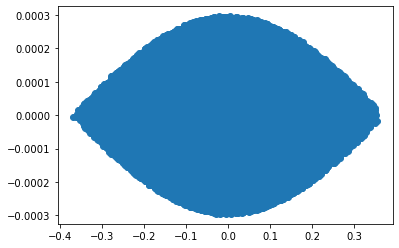

In [38]:
plt.scatter(part.zeta, part.delta)
plt.show()

In [39]:
#line.build_tracker(_context=xo.ContextCpu(omp_num_threads=6))
line.track(part, num_turns=num_turn)

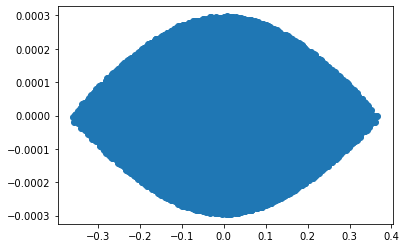

In [40]:
plt.scatter(part.zeta, part.delta)
plt.show()